In [3]:
import lasio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load LAS
las = lasio.read(r"F:\Petrophysics Sabah Basin Malaysia\Petrophysical LAS (26-09-2025)\BATAI-1.las")
df = las.df()

Only engine='normal' can read wrapped files


In [4]:
# Pay zone for hydrocarbon column height
TOP_DEPTH = 1962.76  
BOTTOM_DEPTH = 1963.67 

In [5]:
# Filter data for the specified interval
depth = df.index
mask_interval = (depth >= TOP_DEPTH) & (depth <= BOTTOM_DEPTH)

In [6]:
# Extract logs for the interval
depth_interval = depth[mask_interval]
vsh = df["VSHL_UM"][mask_interval]
phi_e = df["PHIE_UM"][mask_interval]
sw = df["SWA_UM"][mask_interval]

In [7]:
# Remove any NaN values
valid_mask = ~(np.isnan(vsh) | np.isnan(phi_e) | np.isnan(sw))
depth_interval = depth_interval[valid_mask]
vsh = vsh[valid_mask]
phi_e = phi_e[valid_mask]
sw = sw[valid_mask]

In [8]:
# Calculate column parameters
dz = 0.1524  # depth step in meters
column_height = BOTTOM_DEPTH - TOP_DEPTH
actual_data_points = len(depth_interval)

print(f"=== COLUMN ANALYSIS ===")
print(f"Top Depth: {TOP_DEPTH} m")
print(f"Bottom Depth: {BOTTOM_DEPTH} m")
print(f"Column Height: {column_height} m")
print(f"Valid Data Points: {actual_data_points}")
print(f"Depth Step: {dz} m")


=== COLUMN ANALYSIS ===
Top Depth: 1962.76 m
Bottom Depth: 1963.67 m
Column Height: 0.9100000000000819 m
Valid Data Points: 5
Depth Step: 0.1524 m


In [9]:
def calculate_thc_fraction(vsh, phi_e, sw, vsh_cutoff=None, phie_cutoff=None, sw_cutoff=None):
    """
    Calculate Total Hydrocarbon Column as fraction
    THC = Sum(PHIE × So × dz) where So = 1 - Sw
    Returns THC as fraction of total possible hydrocarbon column
    """
    # Apply cutoffs if provided
    mask = np.ones(len(vsh), dtype=bool)
    
    if vsh_cutoff is not None:
        mask = mask & (vsh < vsh_cutoff)
    if phie_cutoff is not None:
        mask = mask & (phi_e > phie_cutoff)
    if sw_cutoff is not None:
        mask = mask & (sw < sw_cutoff)
    
    # Calculate oil saturation
    so = 1 - sw
    
    # Calculate THC for valid points
    thc_absolute = np.sum(mask * phi_e * so) * dz
    
    # Calculate maximum possible THC (if all points had So=1 and PHIE=max)
    max_possible_thc = len(vsh) * dz * np.max(phi_e)
    
    # Return as fraction
    if max_possible_thc > 0:
        thc_fraction = thc_absolute / max_possible_thc
    else:
        thc_fraction = 0
        
    return thc_fraction*100, thc_absolute

In [27]:
# Create cutoff ranges for sensitivity analysis
cutoff_range = np.linspace(0, 1, 51)  # 0 to 1 in steps of 0.02

In [28]:
# 1. THC vs VSH Analysis
print("\n=== Calculating THC vs VSH Sensitivity ===")
thc_vsh_results = []
for vsh_cut in cutoff_range:
    thc_frac, thc_abs = calculate_thc_fraction(vsh, phi_e, sw, vsh_cutoff=vsh_cut)
    thc_vsh_results.append([vsh_cut, thc_frac, thc_abs])

df_thc_vsh = pd.DataFrame(thc_vsh_results, columns=['VSH_Cutoff', 'THC_Fraction', 'THC_Absolute'])


=== Calculating THC vs VSH Sensitivity ===


In [29]:
# 2. THC vs PHIE Analysis  
print("=== Calculating THC vs PHIE Sensitivity ===")
thc_phie_results = []
for phie_cut in cutoff_range:
    thc_frac, thc_abs = calculate_thc_fraction(vsh, phi_e, sw, phie_cutoff=phie_cut)
    thc_phie_results.append([phie_cut, thc_frac, thc_abs])

df_thc_phie = pd.DataFrame(thc_phie_results, columns=['PHIE_Cutoff', 'THC_Fraction', 'THC_Absolute'])

=== Calculating THC vs PHIE Sensitivity ===


In [30]:
# 3. THC vs SW Analysis
print("=== Calculating THC vs SW Sensitivity ===")
thc_sw_results = []
for sw_cut in cutoff_range:
    thc_frac, thc_abs = calculate_thc_fraction(vsh, phi_e, sw, sw_cutoff=sw_cut)
    thc_sw_results.append([sw_cut, thc_frac, thc_abs])

df_thc_sw = pd.DataFrame(thc_sw_results, columns=['SW_Cutoff', 'THC_Fraction', 'THC_Absolute'])

=== Calculating THC vs SW Sensitivity ===


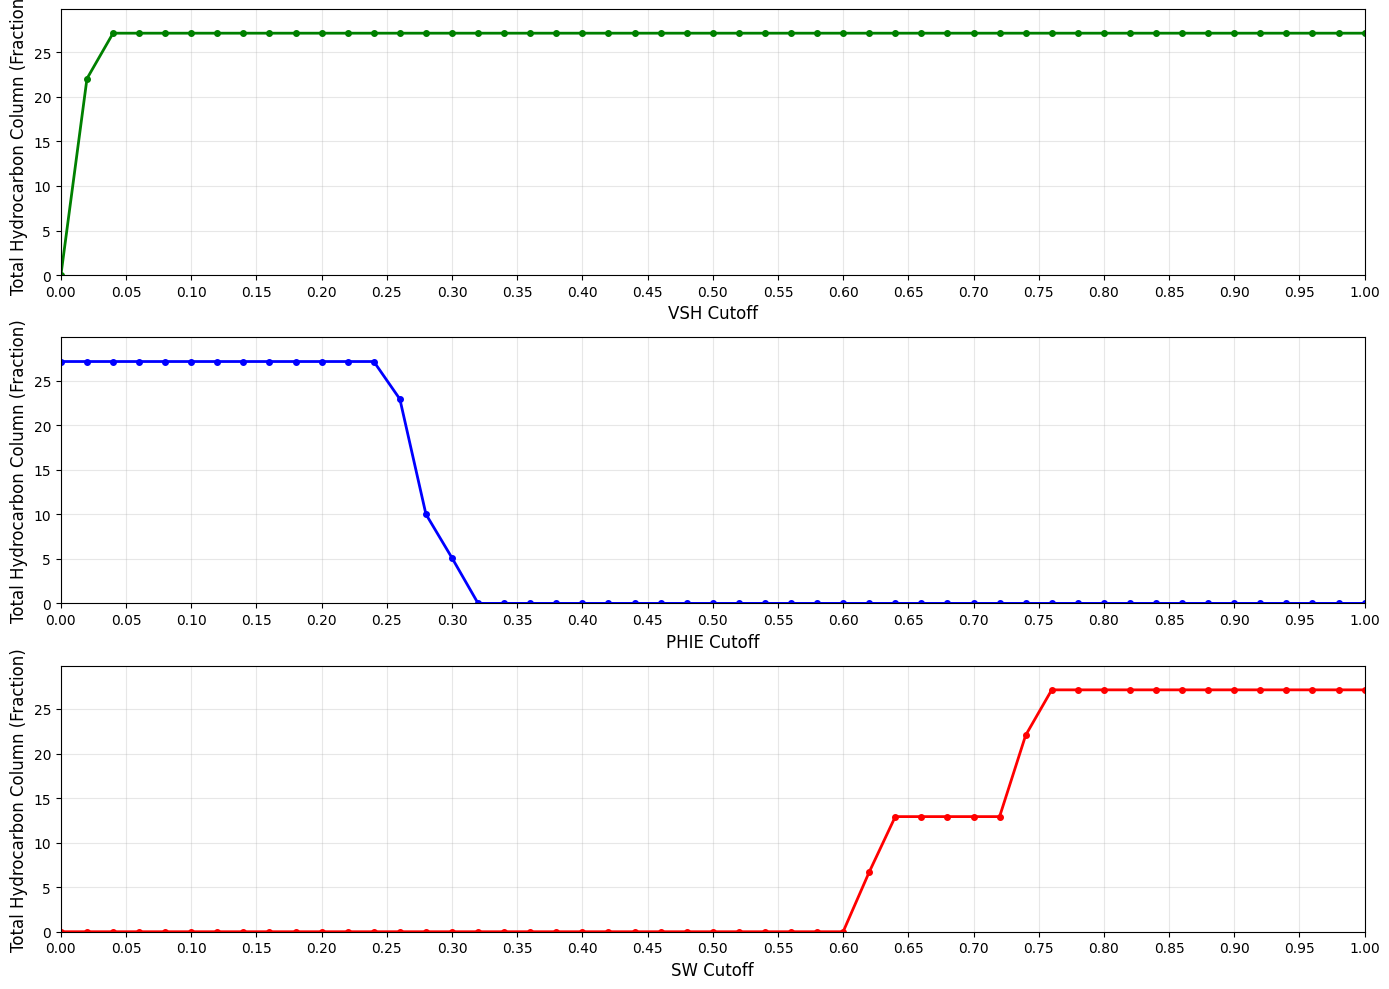

In [41]:
import numpy as np

# Create the three sensitivity plots (column-wise)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10))

# Define common x-ticks
xticks = np.arange(0, 1.05, 0.05)  # ticks every 0.1

# Plot 1: THC vs VSH
ax1.plot(df_thc_vsh['VSH_Cutoff'], df_thc_vsh['THC_Fraction'], 'go-', linewidth=2, markersize=4)
ax1.set_xlabel('VSH Cutoff', fontsize=12)
ax1.set_ylabel('Total Hydrocarbon Column (Fraction)', fontsize=12)
#ax1.set_title('THC vs VSH Cutoff\nSensitivity Analysis', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, max(df_thc_vsh['THC_Fraction']) * 1.1)
ax1.set_xticks(xticks)

# Plot 2: THC vs PHIE
ax2.plot(df_thc_phie['PHIE_Cutoff'], df_thc_phie['THC_Fraction'], 'bo-', linewidth=2, markersize=4)
ax2.set_xlabel('PHIE Cutoff', fontsize=12)
ax2.set_ylabel('Total Hydrocarbon Column (Fraction)', fontsize=12)
#ax2.set_title('THC vs PHIE Cutoff\nSensitivity Analysis', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, max(df_thc_phie['THC_Fraction']) * 1.1)
ax2.set_xticks(xticks)

# Plot 3: THC vs SW
ax3.plot(df_thc_sw['SW_Cutoff'], df_thc_sw['THC_Fraction'], 'ro-', linewidth=2, markersize=4)
ax3.set_xlabel('SW Cutoff', fontsize=12)
ax3.set_ylabel('Total Hydrocarbon Column (Fraction)', fontsize=12)
#ax3.set_title('THC vs SW Cutoff\nSensitivity Analysis', fontsize=12)
ax3.grid(True, alpha=0.3)
ax3.set_xlim(0, 1)
ax3.set_ylim(0, max(df_thc_sw['THC_Fraction']) * 1.1)
ax3.set_xticks(xticks)

plt.tight_layout()
plt.show()


In [55]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Define common x-ticks
xticks = np.arange(0, 1.05, 0.05)

# Create subplot layout (3 rows, 1 column)
fig = make_subplots(
    rows=3, cols=1,
    shared_xaxes=False

)

# Plot 1: THC vs VSH
fig.add_trace(
    go.Scatter(
        x=df_thc_vsh['VSH_Cutoff'],
        y=df_thc_vsh['THC_Fraction'],
        mode='lines+markers',
        line=dict(color='green', width=2),
        marker=dict(size=6),
        name="VSH"
    ),
    row=1, col=1
)

# Plot 2: THC vs PHIE
fig.add_trace(
    go.Scatter(
        x=df_thc_phie['PHIE_Cutoff'],
        y=df_thc_phie['THC_Fraction'],
        mode='lines+markers',
        line=dict(color='blue', width=2),
        marker=dict(size=6),
        name="PHIE"
    ),
    row=2, col=1
)

# Plot 3: THC vs SW
fig.add_trace(
    go.Scatter(
        x=df_thc_sw['SW_Cutoff'],
        y=df_thc_sw['THC_Fraction'],
        mode='lines+markers',
        line=dict(color='red', width=2),
        marker=dict(size=6),
        name="SW"
    ),
    row=3, col=1
)

# Update layout
fig.update_layout(
    height=1000, width=1200,
    title_text="Sensitivity Analysis - Total Hydrocarbon Column (THC)",
    showlegend=False
)

# Update axes for all subplots
fig.update_xaxes(title_text="VSH", row=1, col=1, range=[0,1], tickvals=xticks)
fig.update_xaxes(title_text="PHIE", row=2, col=1, range=[0,1], tickvals=xticks)
fig.update_xaxes(title_text="SW", row=3, col=1, range=[0,1], tickvals=xticks)

fig.update_yaxes(title_text="THC", row=1, col=1)
fig.update_yaxes(title_text="THC", row=2, col=1)
fig.update_yaxes(title_text="THC", row=3, col=1)

fig.show()
